In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans, cmeans_predict
import matplotlib.pyplot as plt
from tqdm import tqdm

# Analisis exploratorio de datos

In [2]:
dataset = pd.read_excel('CaracteristicasExtraidasdeMascaras.xlsx')
dataset.head(5)

,Mascara de donde se extraen características,Texture,Perimeter,Cx,Cy,Concave,Concave_Points,Smoothness,Label
0,1,120.465873,717.002087,127,117,1.090374,220,9,1
1,2,43.380253,193.539104,143,47,1.143877,64,8,1
2,3,60.315121,317.178713,127,69,1.216962,117,10,1
3,4,87.914507,560.173660,125,110,1.312826,191,8,1
4,5,84.541220,490.475175,106,136,1.210341,175,10,1


In [3]:
x_dataset = dataset[['Texture', 'Perimeter', 'Cx', 'Cy', 'Concave', 'Concave_Points', 'Smoothness']]
x_dataset.head()

,Texture,Perimeter,Cx,Cy,Concave,Concave_Points,Smoothness
0,120.465873,717.002087,127,117,1.090374,220,9
1,43.380253,193.539104,143,47,1.143877,64,8
2,60.315121,317.178713,127,69,1.216962,117,10
3,87.914507,560.173660,125,110,1.312826,191,8
4,84.541220,490.475175,106,136,1.210341,175,10


In [4]:
y_dataset = dataset[['Label']]
y_dataset.head()

,Label
0,1
1,1
2,1
3,1
4,1


C:\Users\raulD\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


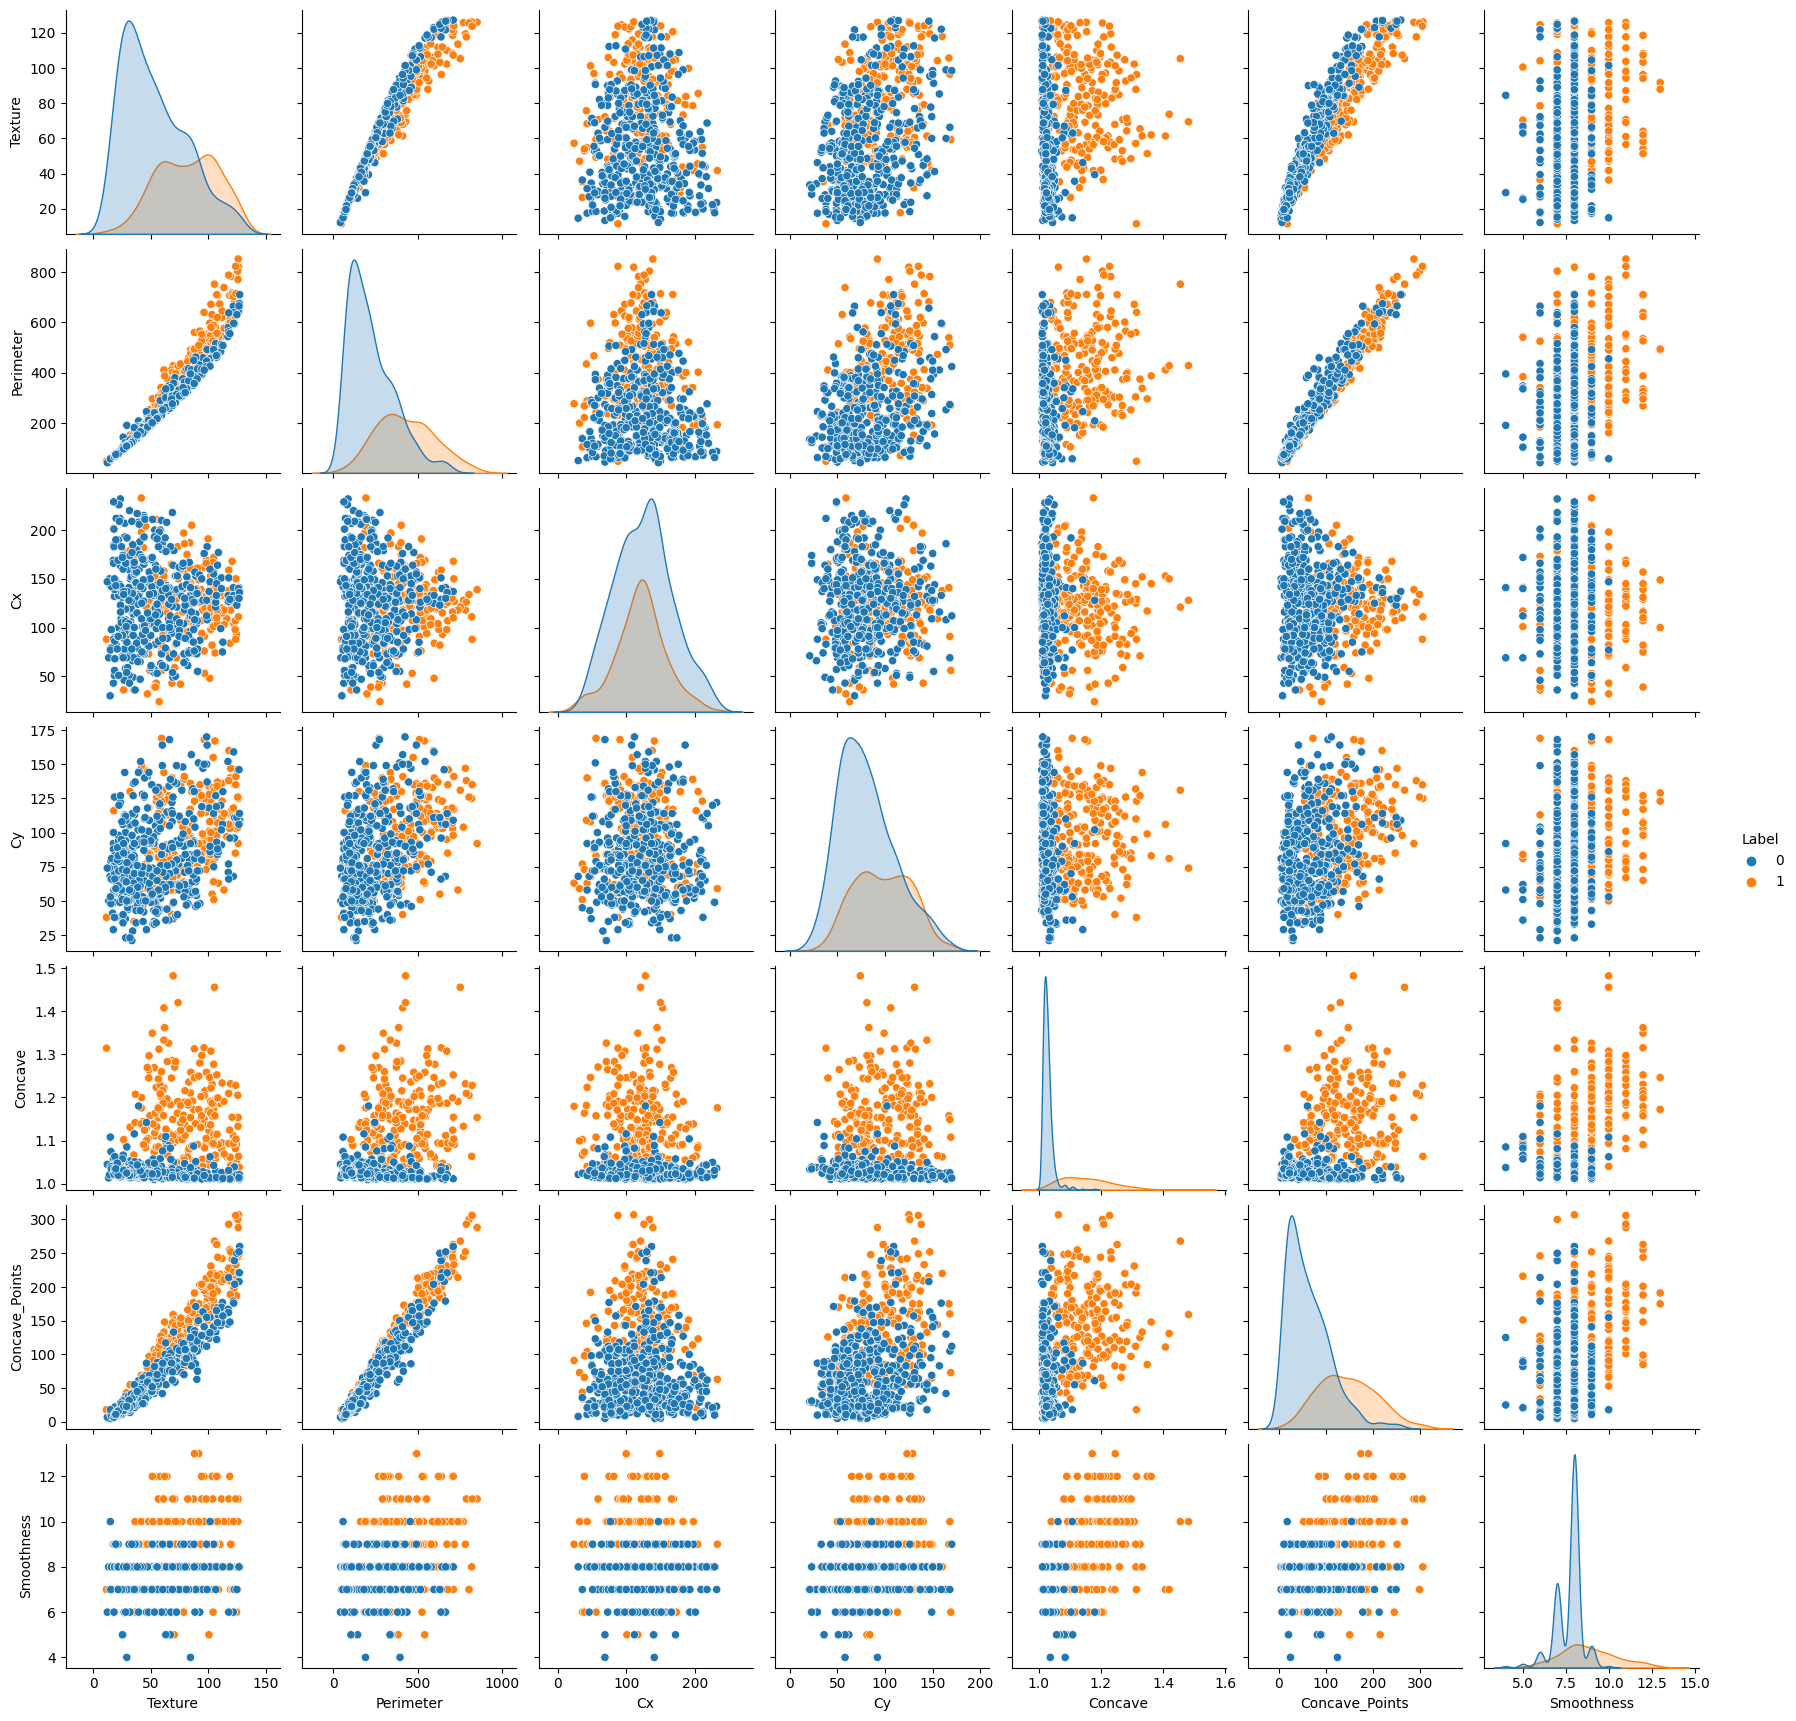

In [5]:
sns.pairplot(pd.concat((x_dataset,y_dataset),axis=1), hue='Label')

<Axes: ylabel='Count'>

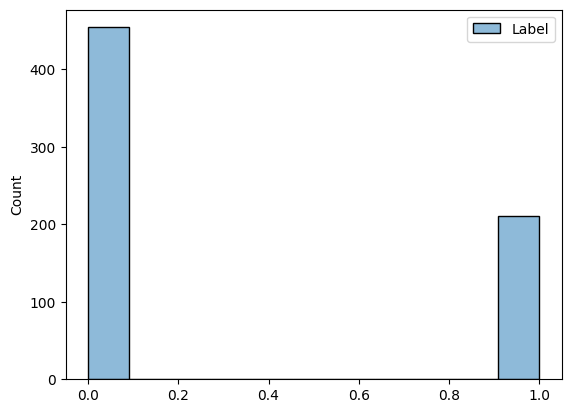

In [6]:
sns.histplot(y_dataset)

<Axes: >

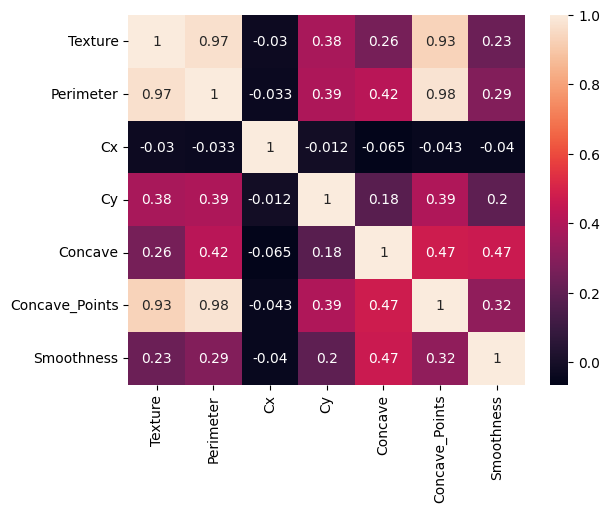

In [7]:
correlation_matrix = x_dataset.corr()
sns.heatmap(correlation_matrix, annot=True)

Texture, Permiter y Concave_Points estan muy relacionados, se dejará perimeter al ser el mas relacionado con los otros dos

In [8]:
x_dataset_filter = x_dataset.drop(['Texture', 'Concave_Points'], axis=1)
x_dataset_filter.head()

,Perimeter,Cx,Cy,Concave,Smoothness
0,717.002087,127,117,1.090374,9
1,193.539104,143,47,1.143877,8
2,317.178713,127,69,1.216962,10
3,560.173660,125,110,1.312826,8
4,490.475175,106,136,1.210341,10


<Axes: >

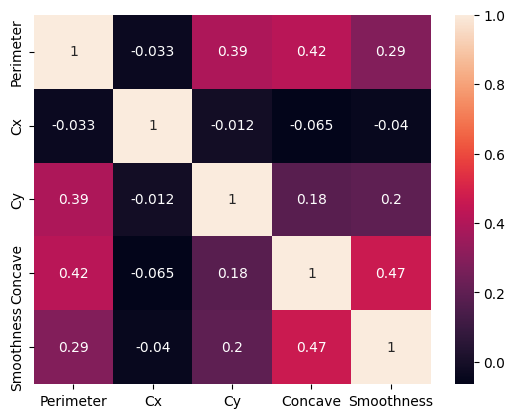

In [9]:
correlation_matrix = x_dataset_filter.corr()
sns.heatmap(correlation_matrix, annot=True)

# Scaling the data

In [10]:
x_scaled = StandardScaler().fit_transform(x_dataset_filter)

C:\Users\raulD\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


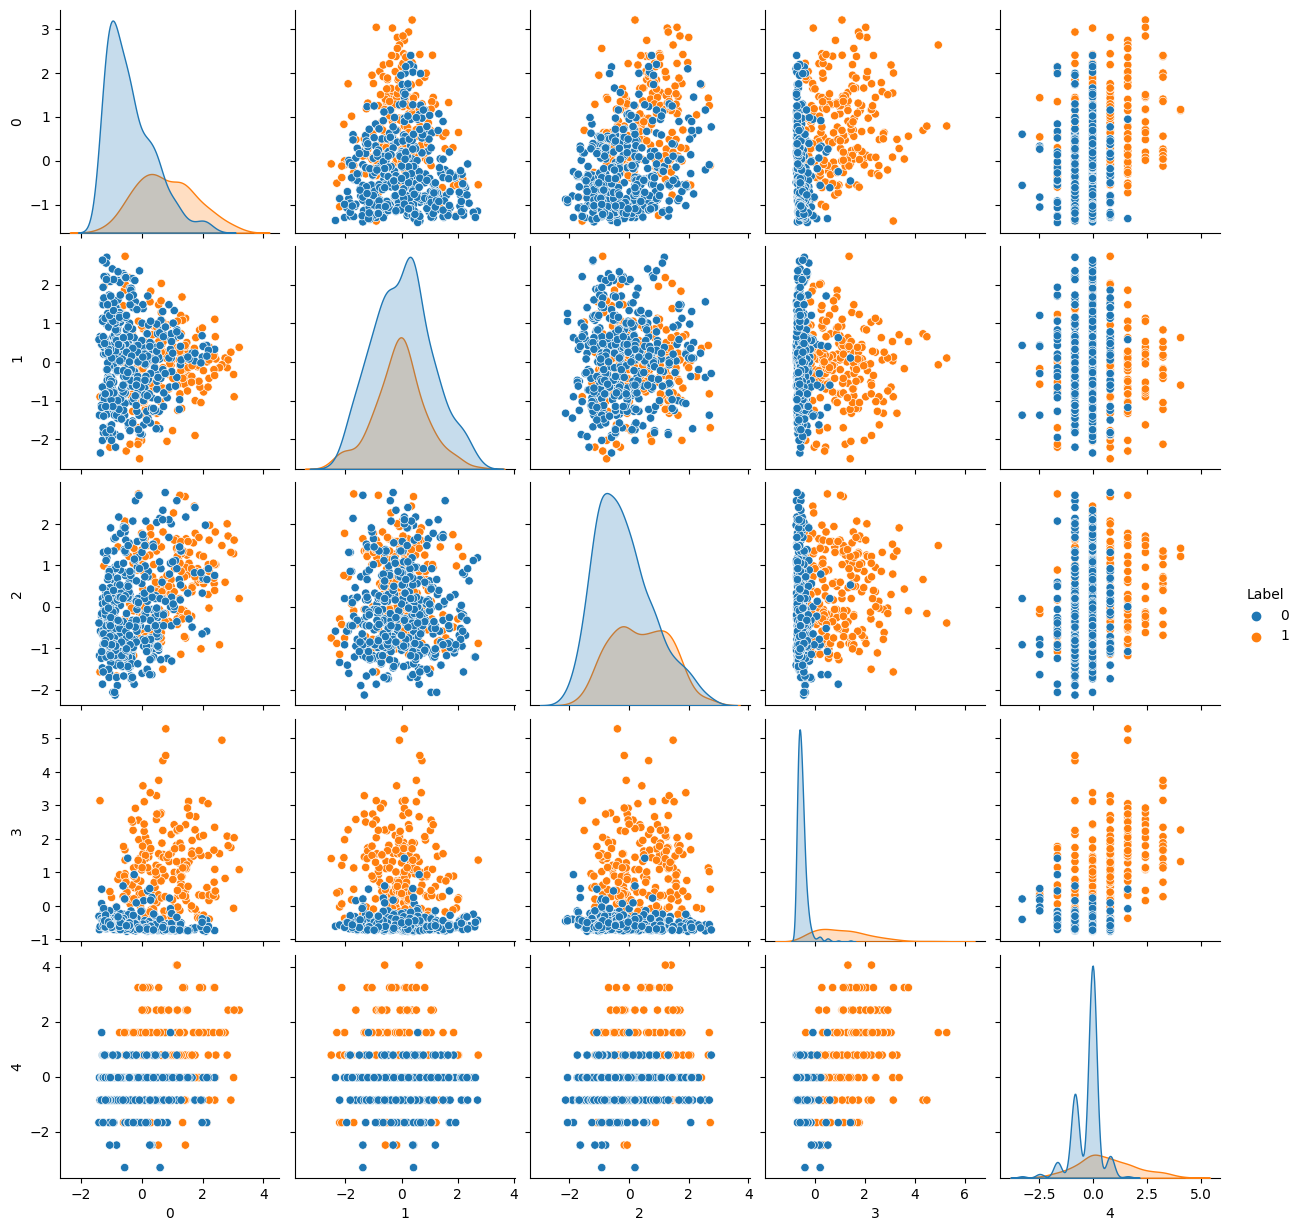

In [11]:
sns.pairplot(pd.concat((pd.DataFrame(x_scaled),y_dataset),axis=1),hue='Label')

# Split the data

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_dataset.values,test_size=0.2,random_state=42)

In [13]:
y_train.shape, y_test.shape

((532, 1), (133, 1))

# Training

### K Means

In [14]:
def cluster_equvalence(clusters, labels, predicts):
    if labels.size != predicts.size:
        raise Exception('Labels and Predicts arrays are from different sizes')
    
    labels_count = {cluster: {0:0, 1:0} for cluster in range(clusters)}
    for label, predict in zip(labels, predicts):
        labels_count[predict][label] += 1
    predict_equivalence = {cluster: 0 if labels_count[cluster][0] > labels_count[cluster][1] else 1
                           for cluster in range(clusters)}
    return predict_equivalence
def predict_transform(predict_equivalence, predicts):
    predicts_transformed = np.array([predict_equivalence[predict] for predict in predicts], dtype=np.int64)
    return predicts_transformed

In [ ]:
param_grid = {
    'n_clusters': list(range(2,532+1)),
    'init': ['k-means++'], #k-means++
    'n_init': [1],
    'random_state':list(range(0,15)),
    'tol':[10**(i) for i in range(-1,-5,-1)],
}
kmeans_permutations = list()
for params in tqdm(ParameterGrid(param_grid)):
    kmeans = KMeans(**params)
    kmeans.fit(x_train)
    
    clusters = params['n_clusters']
    
    predicts_train = kmeans.predict(x_train)
    predict_equivalence = cluster_equvalence(clusters, np.squeeze(y_train), predicts_train)
    predicts_transformed = predict_transform(predict_equivalence, predicts_train)
    accuracy_train = accuracy_score(y_train, predicts_transformed)

    predicts_test = kmeans.predict(x_test)
    predict_equivalence = cluster_equvalence(clusters, np.squeeze(y_test), predicts_test)
    predicts_transformed = predict_transform(predict_equivalence, predicts_test)
    accuracy_test = accuracy_score(y_test, predicts_transformed)

    kmeans_permutations.append((kmeans, accuracy_train, accuracy_test))

100%|██████████| 31860/31860 [21:53<00:00, 24.25it/s]


In [127]:
kmeans_permutations = sorted(kmeans_permutations, key=lambda model:(model[2],model[1]),reverse=True) # lo organiza por accuracy de test y si hay empate decide por accuracy de train

In [128]:
kmeans_permutations[:5]

[(KMeans(n_clusters=458, n_init=1, random_state=4, tol=0.1),
  1.0,
  0.9849624060150376),
 (KMeans(n_clusters=458, n_init=1, random_state=4, tol=0.01),
  1.0,
  0.9849624060150376),
 (KMeans(n_clusters=458, n_init=1, random_state=4, tol=0.001),
  1.0,
  0.9849624060150376),
 (KMeans(n_clusters=458, n_init=1, random_state=4), 1.0, 0.9849624060150376),
 (KMeans(n_clusters=459, n_init=1, random_state=3, tol=0.1),
  1.0,
  0.9849624060150376)]

##### Clusters

In [157]:
df_accuracy_kmeans = pd.DataFrame([(permutation[1],permutation[2],permutation[0].n_clusters) for permutation in kmeans_permutations])
df_accuracy_kmeans.columns = ['accuracy_train','accuracy_test', 'clusters']
df_accuracy_kmeans.head(30)

,accuracy_train,accuracy_test,clusters
0,1.0,0.984962,458
1,1.0,0.984962,458
2,1.0,0.984962,458
3,1.0,0.984962,458
4,1.0,0.984962,459
5,1.0,0.984962,459
6,1.0,0.984962,459
7,1.0,0.984962,459
8,1.0,0.984962,459
9,1.0,0.984962,459


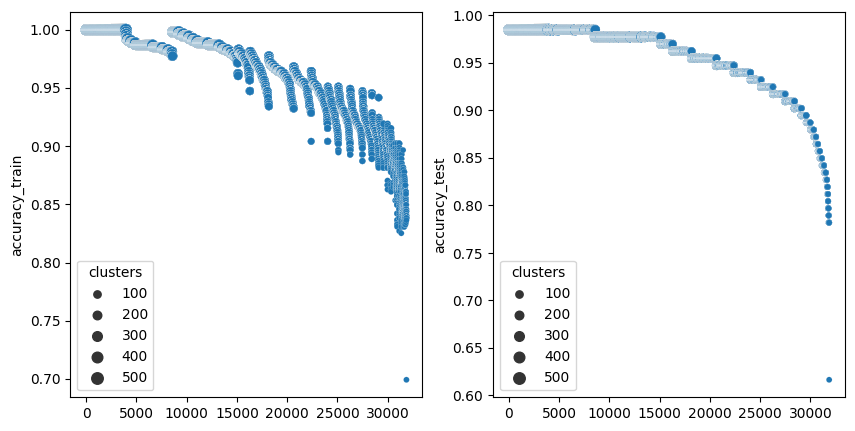

In [143]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
titles = ['accuracy_train','accuracy_test']
for title, ax in zip(titles, axs):
    sns.scatterplot(data=df_accuracy_kmeans, y=df_accuracy_kmeans[title],x=range(len(df_accuracy_kmeans)),ax=ax,size='clusters',linewidth=0.1)

In [37]:
df_mean_values_kmeans = df_accuracy_kmeans.groupby('clusters')[['accuracy_train','accuracy_test']].mean().reset_index()
df_mean_values_kmeans.columns = ['clusters', 'mean_accuracy_train', 'mean_accuracy_test']
# Display the result
print(df_mean_values_kmeans)

     clusters  mean_accuracy_train  mean_accuracy_test
0           2             0.881986            0.861529
1           3             0.861028            0.810150
2           4             0.853791            0.798371
3           5             0.852506            0.815038
4           6             0.845457            0.827318
..        ...                  ...                 ...
526       528             1.000000            0.984962
527       529             1.000000            0.984962
528       530             1.000000            0.984962
529       531             1.000000            0.984962
530       532             1.000000            0.984962

[531 rows x 3 columns]


In [49]:
axs

array([<Axes: >, <Axes: >], dtype=object)

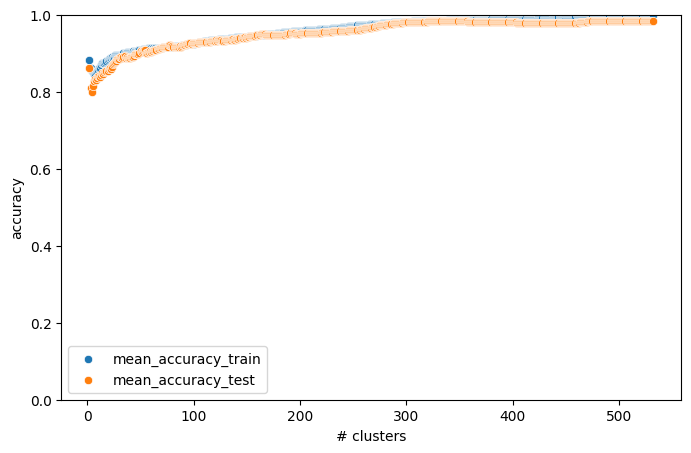

In [58]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
titles = ['mean_accuracy_train', 'mean_accuracy_test']
for title in titles:
    sns.scatterplot(df_mean_values_kmeans, x='clusters', y=title, ax=axs, label=title)
    axs.set_ylim(0, 1)
    axs.set_ylabel('accuracy')
    axs.set_xlabel('# clusters')

##### Tolerance

In [66]:
df_tolerance_kmeans = pd.DataFrame([(permutation[1],permutation[2],permutation[0].get_params()['tol']) for permutation in kmeans_permutations])
df_tolerance_kmeans.columns = ['accuracy_train','accuracy_test', 'tolerance']
df_tolerance_kmeans

,accuracy_train,accuracy_test,tolerance
0,1.000000,0.984962,0.1000
1,1.000000,0.984962,0.0100
2,1.000000,0.984962,0.0010
3,1.000000,0.984962,0.0001
4,1.000000,0.984962,0.1000
...,...,...,...
31855,0.838346,0.781955,0.0010
31856,0.838346,0.781955,0.1000
31857,0.838346,0.781955,0.0100
31858,0.836466,0.781955,0.1000


In [ ]:
df_tolerance_values_kmeans = df_tolerance_kmeans.groupby('tolerance')[['accuracy_train','accuracy_test']].mean().reset_index()
df_tolerance_values_kmeans.columns = ['tolerance', 'mean_accuracy_train', 'mean_accuracy_test']
# Display the result
print(df_tolerance_values_kmeans)

   tolerance  mean_accuracy_train  mean_accuracy_test
0     0.0001             0.961752            0.953823
1     0.0010             0.961753            0.953828
2     0.0100             0.961754            0.953820
3     0.1000             0.961738            0.953722


In [86]:
df_tolerance_melted = df_tolerance_values_kmeans.melt(id_vars=['tolerance'], value_vars=['mean_accuracy_train', 'mean_accuracy_test'], var_name='type', value_name='accuracy')
df_tolerance_melted

,tolerance,type,accuracy
0,0.0001,mean_accuracy_train,0.961752
1,0.0010,mean_accuracy_train,0.961753
2,0.0100,mean_accuracy_train,0.961754
3,0.1000,mean_accuracy_train,0.961738
4,0.0001,mean_accuracy_test,0.953823
5,0.0010,mean_accuracy_test,0.953828
6,0.0100,mean_accuracy_test,0.953820
7,0.1000,mean_accuracy_test,0.953722


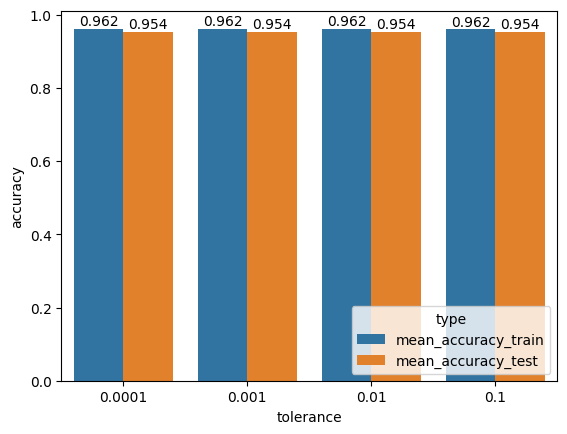

In [111]:
ax = sns.barplot(df_tolerance_melted, x='tolerance', y='accuracy', hue='type')
plt.legend(title='type', loc='lower right')
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f')

### FC means

In [ ]:
param_grid = {
    'data':[x_train.T],
    'c': list(range(2,100)),
    'm': list(range(2,6)),
    'error': [10**(i) for i in range(-1,-5,-1)],
    'maxiter':[300],
    'metric':['euclidean'],
    'seed':list(range(0,10)),
}

fcmeans_permutations = list()
for params in tqdm(ParameterGrid(param_grid)):
    centers, _, _, _, _, _, fpc = cmeans(**params)
    
    clusters = params['c']
    m = params['m']
    error = params['error']
    maxiter = params['maxiter']
    
    predicts_train, _, _, _, _, fpc_train = cmeans_predict(test_data=x_train.T, cntr_trained=centers, m=m, error=error, maxiter=maxiter) # Fuzzy prediction matrix
    predicts_train = np.argmax(predicts_train,axis=0) # Takes the cluster with max ownership value
    predict_equivalence = cluster_equvalence(clusters, np.squeeze(y_train), predicts_train)
    predicts_transformed = predict_transform(predict_equivalence, predicts_train)
    accuracy_train = accuracy_score(y_train, predicts_transformed)

    predicts_test, _, _, _, _, fpc_test = cmeans_predict(test_data=x_test.T, cntr_trained=centers, m=m, error=error, maxiter=maxiter) # Fuzzy prediction matrix
    predicts_test = np.argmax(predicts_test,axis=0) # Takes the cluster with max ownership value
    predict_equivalence = cluster_equvalence(clusters, np.squeeze(y_test), predicts_test)
    predicts_transformed = predict_transform(predict_equivalence, predicts_test)
    accuracy_test = accuracy_score(y_test, predicts_transformed)

    params['centers'] = centers
    params['fpc_train'] = fpc_train
    params['fpc_test'] = fpc_test
    fcmeans_permutations.append((params, accuracy_train, accuracy_test))

100%|██████████| 15680/15680 [34:44<00:00,  7.52it/s] 


In [59]:
fcmeans_permutations = sorted(fcmeans_permutations, key=lambda model:(model[2],model[1]),reverse=True)
fcmeans_permutations[:5]

[({'c': 61,
   'data': array([[ 0.79133506, -0.13757023,  1.1558957 , ..., -1.15447433,
           -0.24195401, -0.26813399],
          [ 0.10150894,  0.25185069,  0.82816072, ...,  1.05367334,
           -0.24928847, -1.70259203],
          [-0.39096159, -0.48929345, -0.3581843 , ..., -0.03041141,
            1.14957099, -0.09596599],
          [ 5.28603717, -0.6394556 , -0.33884255, ..., -0.50326461,
           -0.65196866,  1.13525183],
          [ 1.60345548, -0.03071754, -0.03071754, ..., -0.03071754,
           -0.03071754, -0.03071754]]),
   'error': 0.1,
   'm': 5,
   'maxiter': 300,
   'metric': 'euclidean',
   'seed': 1,
   'centers': array([[-4.03340322e-02, -2.97829823e-02,  4.82047186e-02,
           -2.21604236e-02,  3.31296291e-02],
          [-1.18908520e-01, -4.02057206e-03, -8.60131030e-02,
           -5.49887248e-02, -5.53224488e-02],
          [-6.68279846e-02, -3.19677050e-02, -3.57746667e-02,
           -1.75706599e-02,  3.42325727e-02],
          [-4.15388751e-03

##### Clusters

In [ ]:
df_accuracy_fcmeans = pd.DataFrame([(permutation[1],permutation[2],permutation[0]['fpc_train'],permutation[0]['fpc_test'],permutation[0]['c']) for permutation in fcmeans_permutations])
df_accuracy_fcmeans.columns = ['accuracy_train','accuracy_test','fpc_train','fpc_test','clusters']
df_accuracy_fcmeans

,accuracy_train,accuracy_test,fpc_train,fpc_test,clusters
0,0.926692,0.947368,0.016398,0.016397,61
1,0.926692,0.947368,0.015877,0.015876,63
2,0.924812,0.947368,0.016133,0.016132,62
3,0.922932,0.947368,0.016671,0.016670,60
4,0.907895,0.947368,0.119808,0.035375,87
...,...,...,...,...,...
15675,0.723684,0.736842,0.500056,0.500048,2
15676,0.718045,0.729323,0.500142,0.500098,2
15677,0.725564,0.676692,0.500030,0.500025,2
15678,0.699248,0.616541,0.500119,0.500105,2


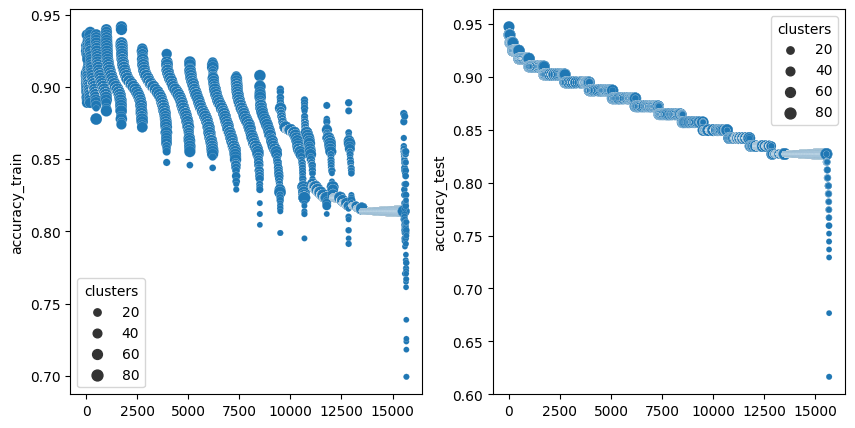

In [144]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
titles = ['accuracy_train','accuracy_test']
for title, ax in zip(titles, axs):
    sns.scatterplot(data=df_accuracy_fcmeans, y=df_accuracy_fcmeans[title],x=range(len(df_accuracy_fcmeans)), size='clusters',ax=ax, linewidth=0.1)

In [62]:
df_mean_values_fcmeans = df_accuracy_fcmeans.groupby('clusters')[['accuracy_train','accuracy_test']].mean().reset_index()
df_mean_values_fcmeans.columns = ['clusters', 'mean_accuracy_train', 'mean_accuracy_test']
# Display the result
print(df_mean_values_fcmeans)

    clusters  mean_accuracy_train  mean_accuracy_test
0          2             0.820042            0.826504
1          3             0.845818            0.845912
2          4             0.843844            0.832143
3          5             0.844126            0.839850
4          6             0.846100            0.843797
..       ...                  ...                 ...
93        95             0.872944            0.876175
94        96             0.873520            0.877491
95        97             0.874730            0.878947
96        98             0.874483            0.878289
97        99             0.874847            0.878947

[98 rows x 3 columns]


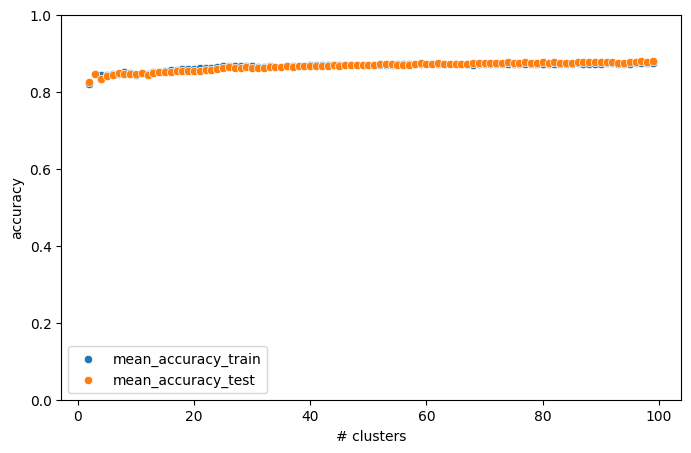

In [63]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
titles = ['mean_accuracy_train', 'mean_accuracy_test']
for title in titles:
    sns.scatterplot(df_mean_values_fcmeans, x='clusters', y=title, ax=axs, label=title)
    axs.set_ylim(0, 1)
    axs.set_ylabel('accuracy')
    axs.set_xlabel('# clusters')

##### FPC

In [145]:
df_mean_fpc_fcmeans = df_accuracy_fcmeans.groupby('clusters')[['fpc_train','fpc_test']].mean().reset_index()
df_mean_fpc_fcmeans.columns = ['clusters', 'mean_fpc_train', 'mean_fpc_test']
# Display the result
print(df_mean_fpc_fcmeans)

    clusters  mean_fpc_train  mean_fpc_test
0          2        0.525199       0.520744
1          3        0.361930       0.357900
2          4        0.283159       0.278050
3          5        0.230096       0.225892
4          6        0.194094       0.190881
..       ...             ...            ...
93        95        0.031500       0.014796
94        96        0.031551       0.014658
95        97        0.031570       0.014445
96        98        0.031483       0.014414
97        99        0.031435       0.014359

[98 rows x 3 columns]


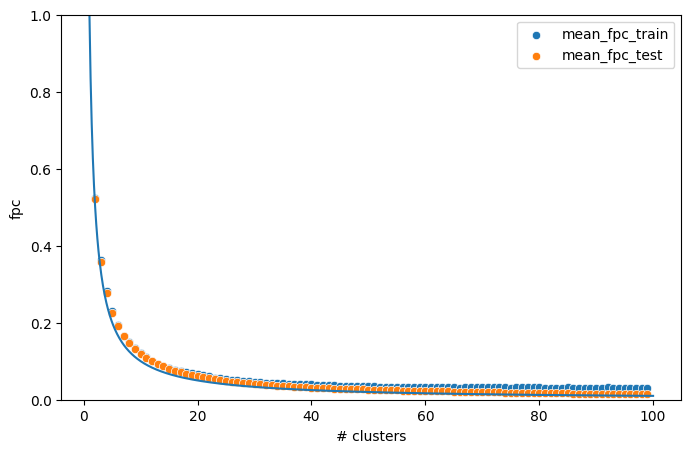

In [152]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
titles = ['mean_fpc_train', 'mean_fpc_test']
x_val = np.linspace(1,100,1000)
y_val = np.vectorize(lambda x: 1/x)(x_val)
axs.plot(x_val,y_val)
for title in titles:
    sns.scatterplot(df_mean_fpc_fcmeans, x='clusters', y=title, ax=axs, label=title)
    axs.set_ylim(0, 1)
    axs.set_ylabel('fpc')
    axs.set_xlabel('# clusters')

##### m

In [115]:
df_fcmeans = pd.DataFrame([(permutation[1],permutation[2],permutation[0]['m'],permutation[0]['error']) for permutation in fcmeans_permutations])
df_fcmeans.columns = ['accuracy_train','accuracy_test','m','tolerance']
df_fcmeans

,accuracy_train,accuracy_test,m,tolerance
0,0.926692,0.947368,5,0.10
1,0.926692,0.947368,5,0.10
2,0.924812,0.947368,5,0.10
3,0.922932,0.947368,5,0.10
4,0.907895,0.947368,2,0.01
...,...,...,...,...
15675,0.723684,0.736842,2,0.10
15676,0.718045,0.729323,3,0.10
15677,0.725564,0.676692,3,0.10
15678,0.699248,0.616541,2,0.10


In [116]:
df_m_values_fcmeans = df_fcmeans.groupby('m')[['accuracy_train','accuracy_test']].mean().reset_index()
df_m_values_fcmeans.columns = ['m', 'mean_accuracy_train', 'mean_accuracy_test']
# Display the result
print(df_m_values_fcmeans)

   m  mean_accuracy_train  mean_accuracy_test
0  2             0.889720            0.887464
1  3             0.874316            0.866399
2  4             0.850147            0.855545
3  5             0.850014            0.855280


In [118]:
df_m_melt = df_m_values_fcmeans.melt(id_vars=['m'], value_vars=['mean_accuracy_train', 'mean_accuracy_test'], var_name='type', value_name='accuracy')
df_m_melt

,m,type,accuracy
0,2,mean_accuracy_train,0.889720
1,3,mean_accuracy_train,0.874316
2,4,mean_accuracy_train,0.850147
3,5,mean_accuracy_train,0.850014
4,2,mean_accuracy_test,0.887464
5,3,mean_accuracy_test,0.866399
6,4,mean_accuracy_test,0.855545
7,5,mean_accuracy_test,0.855280


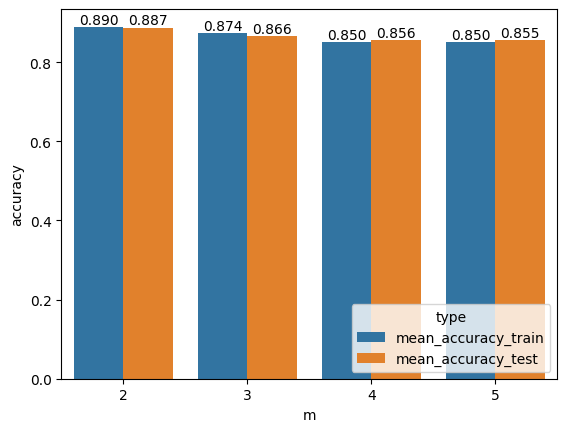

In [119]:
ax = sns.barplot(df_m_melt, x='m', y='accuracy', hue='type')
plt.legend(title='type', loc='lower right')
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f')

##### Tolerance

In [120]:
df_tol_values_fcmeans = df_fcmeans.groupby('tolerance')[['accuracy_train','accuracy_test']].mean().reset_index()
df_tol_values_fcmeans.columns = ['tolerance', 'mean_accuracy_train', 'mean_accuracy_test']
# Display the result
print(df_tol_values_fcmeans)

   tolerance  mean_accuracy_train  mean_accuracy_test
0     0.0001             0.846014            0.848429
1     0.0010             0.849275            0.854688
2     0.0100             0.876260            0.876485
3     0.1000             0.892647            0.885087


In [124]:
df_tol_melt = df_tol_values_fcmeans.melt(id_vars=['tolerance'], value_vars=['mean_accuracy_train', 'mean_accuracy_test'], var_name='type', value_name='accuracy')
df_tol_melt

,tolerance,type,accuracy
0,0.0001,mean_accuracy_train,0.846014
1,0.0010,mean_accuracy_train,0.849275
2,0.0100,mean_accuracy_train,0.876260
3,0.1000,mean_accuracy_train,0.892647
4,0.0001,mean_accuracy_test,0.848429
5,0.0010,mean_accuracy_test,0.854688
6,0.0100,mean_accuracy_test,0.876485
7,0.1000,mean_accuracy_test,0.885087


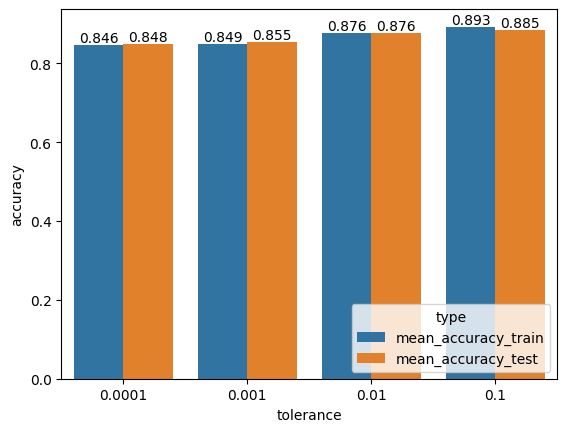

In [125]:
ax = sns.barplot(df_tol_melt, x='tolerance', y='accuracy', hue='type')
plt.legend(title='type', loc='lower right')
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f')